In [17]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, facecolor="white")

### 1. load data
Using `V1_Breast_Cancer_Block_A_Section_1` dataset from 10x Genomics Visium.

In [19]:
adata = sc.datasets.visium_sge(sample_id='V1_Breast_Cancer_Block_A_Section_1')
adata.var_names_make_unique()
print(adata)


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/Users/gloriasong/anaconda3/envs/single_cell_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/gloriasong/anaconda3/envs/single_cell_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### Initial visualize

Spatial expression data of breast cancer tissue sections.

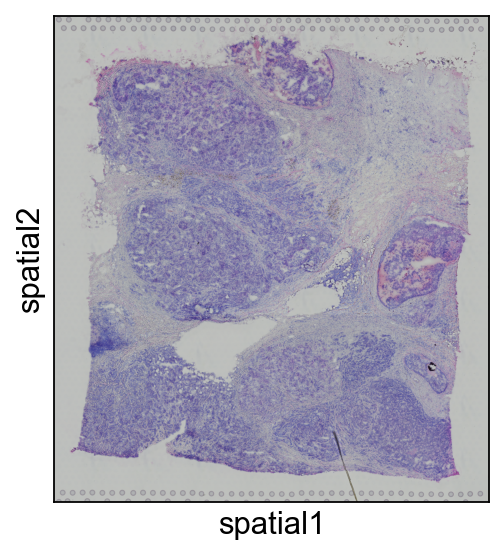

In [20]:
sc.pl.spatial(adata, img_key="hires")


The axes `spatial1` and `spatial2` are spatial coordinate axes, representing the distribution of Visium spots in the tissue.

Also can select specific genes to observe their spatial expression patterns on the tissue.

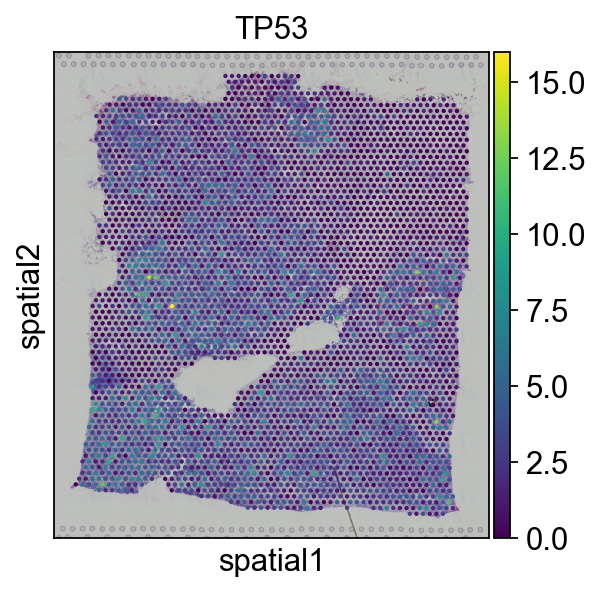

In [21]:
sc.pl.spatial(adata, color=["TP53"], img_key="hires")

Those Black Hexagonal Grid represent spatial gene expression spots.

Each spot captures RNA from multiple cells and measures the expression level(count) of the TP53 gene.

High TP53 expression (yellow regions) may indicate active tumor areas or mutation-related upregulation.

### QC

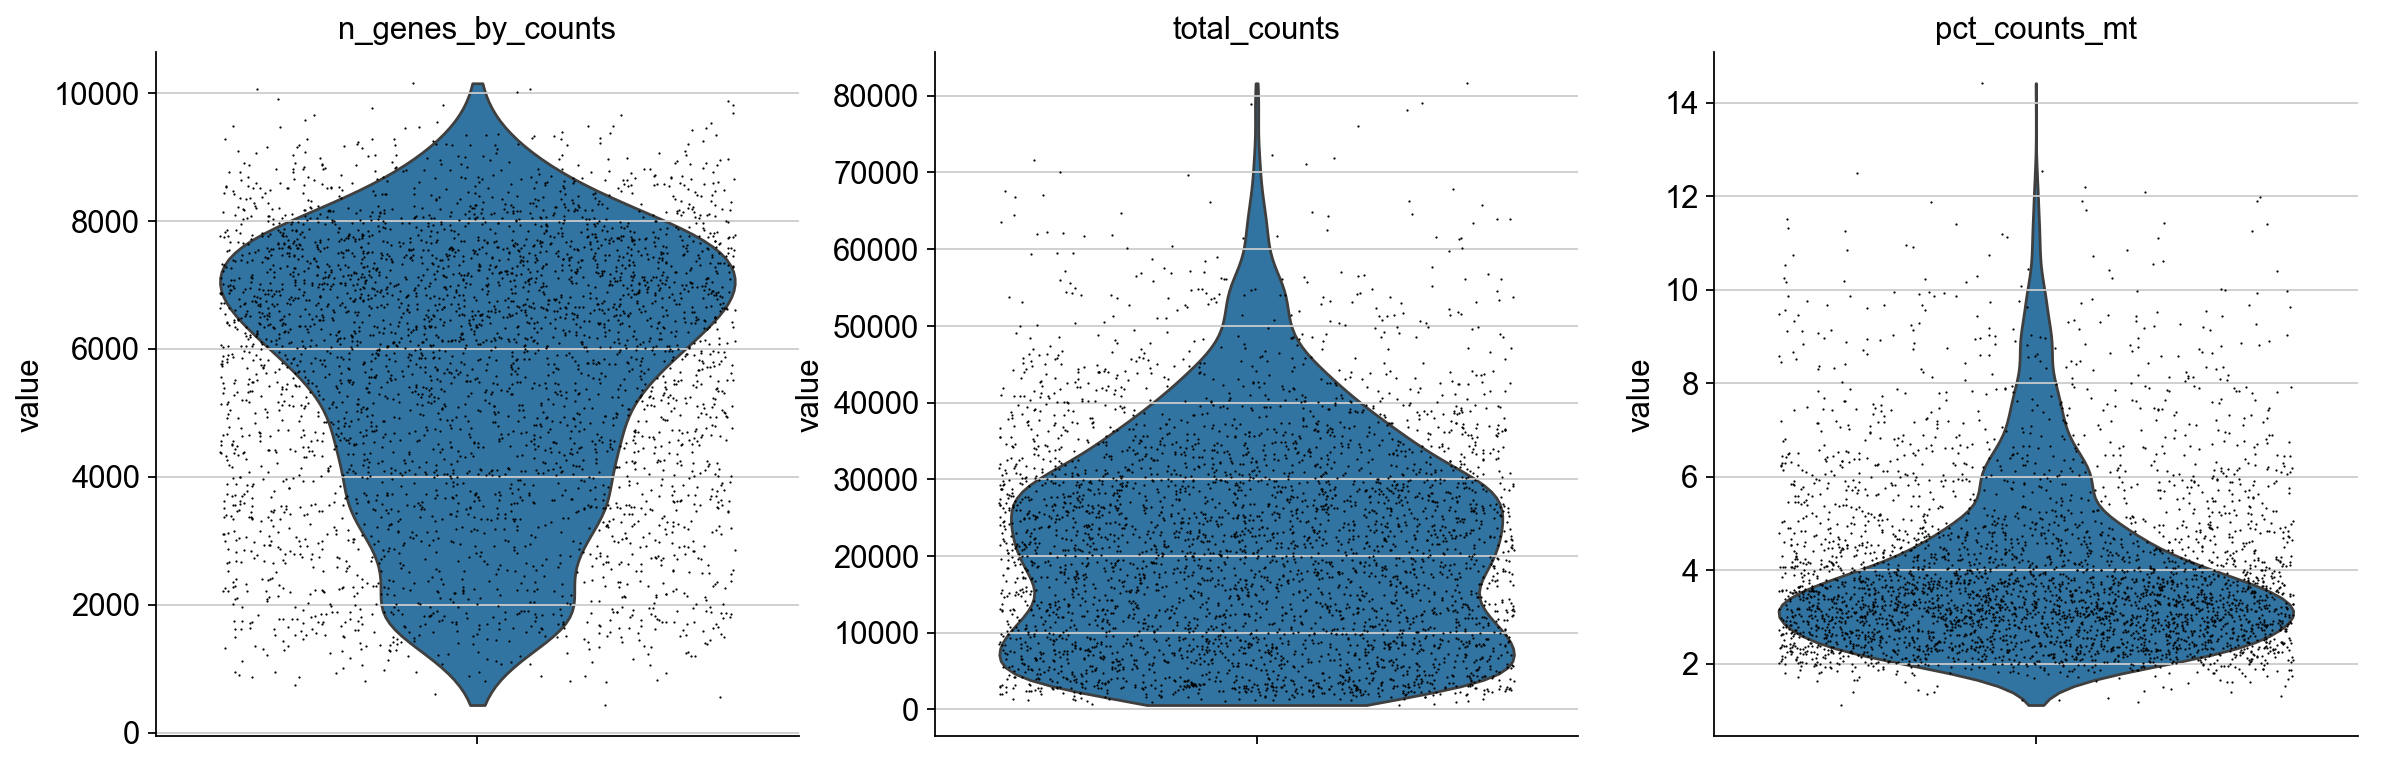

In [22]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, log1p=True
)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


In [23]:
# Filtering
adata = adata[
    (adata.obs["total_counts"] > 5000) & 
    (adata.obs["total_counts"] < 50000) & 
    (adata.obs["n_genes_by_counts"] > 1000) & 
    (adata.obs["pct_counts_mt"] < 20),
    :
]

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")


Number of cells after filtering of low quality cells: 3251


In 10x Genomics Visium spatial transcriptomics (ST) data, doublet detection is usually not necessary. 
- Each Spot Contains Multiple Cells.
- Doublets do not significantly affect analysis like in single-cell RNA-seq.
- In ST, each spot inherently contains mixed RNA, so doublets are usually not a major technical issue.
- ST is mainly used for spatial gene expression analysis, not single-cell classification.

### 3. Normalization

In [24]:
adata = adata.copy()
# adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
 # store normalized data for PCA, clustering, etc.

### 4. Feature Selection

Similar, in spatial transcriptomics (ST) data, feature selection aims to identify highly variable genes (HVGs) for dimensionality reduction (PCA/UMAP) and clustering analysis.



/Users/gloriasong/anaconda3/envs/single_cell_env/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


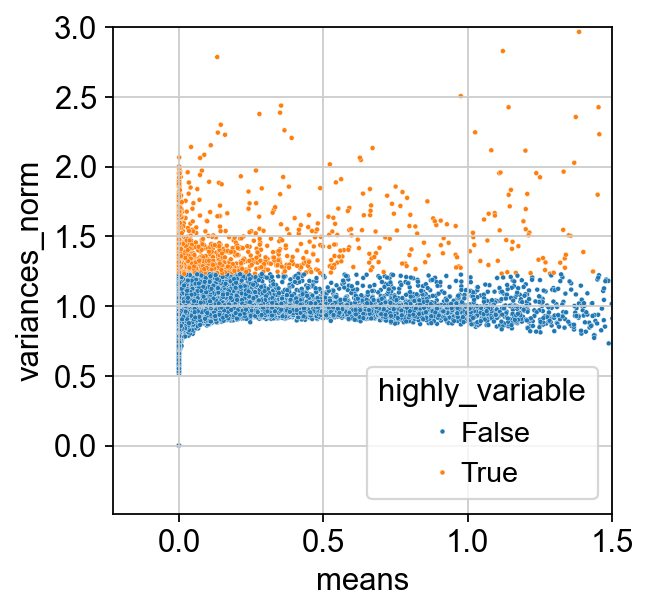

In [25]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)

ax = sns.scatterplot(
    data=adata.var, x="means", y="variances_norm", hue="highly_variable", s=5
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.show()

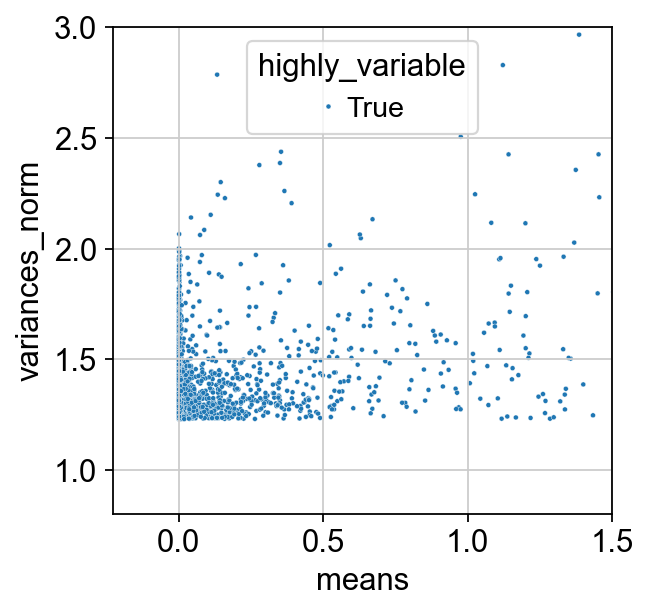

In [26]:
# filtering
adata = adata[:, adata.var["highly_variable"]]

ax = sns.scatterplot(
    data=adata.var, x="means", y="variances_norm", hue="highly_variable", s=5
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.show()

### 5. Dimensionality Reduction

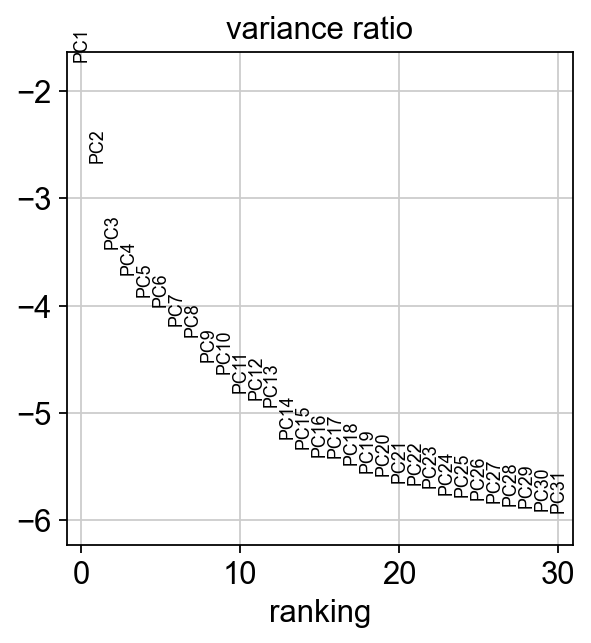

In [27]:
adata = adata.copy()
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata, log=True)

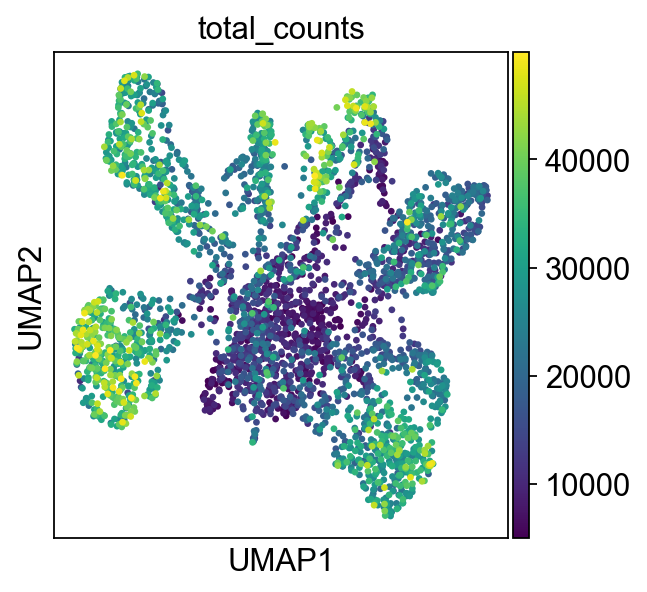

In [28]:
# neighborhood graph
sc.pp.neighbors(adata, n_pcs=15)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["total_counts"])

### 6. Clustering

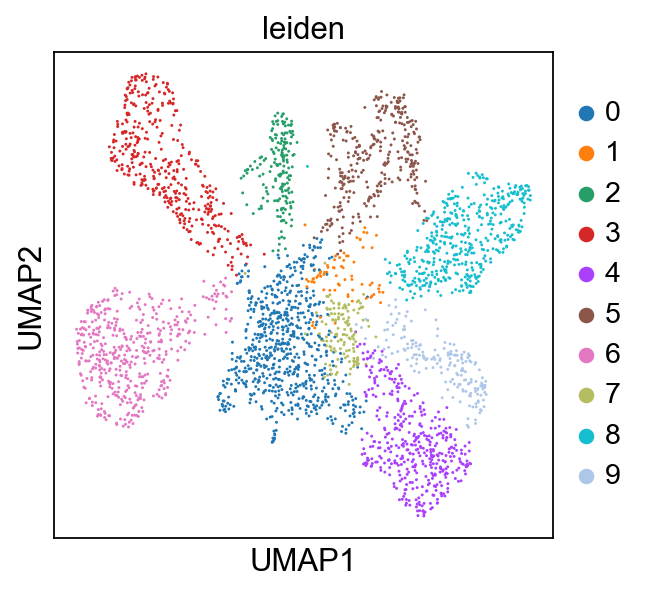

In [29]:
sc.tl.leiden(adata, flavor="igraph",
             n_iterations=2, resolution=0.5)
sc.pl.umap(adata, color=["leiden"], size=7)

*!! I got trouble with import squidpy.*

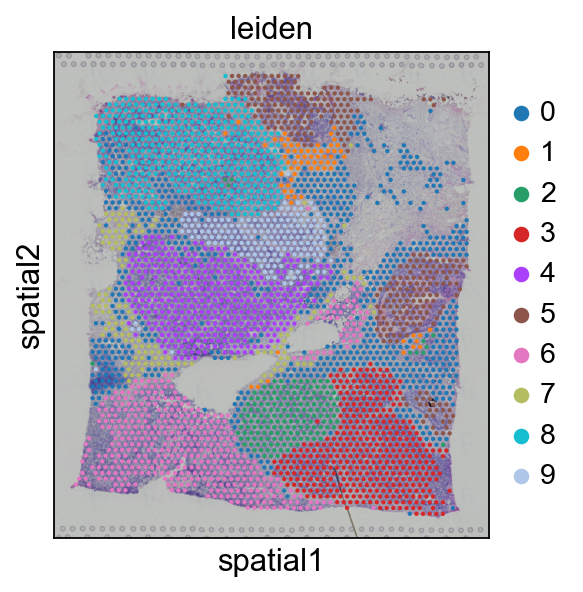

In [30]:
sc.pl.spatial(adata, color="leiden", img_key="hires")

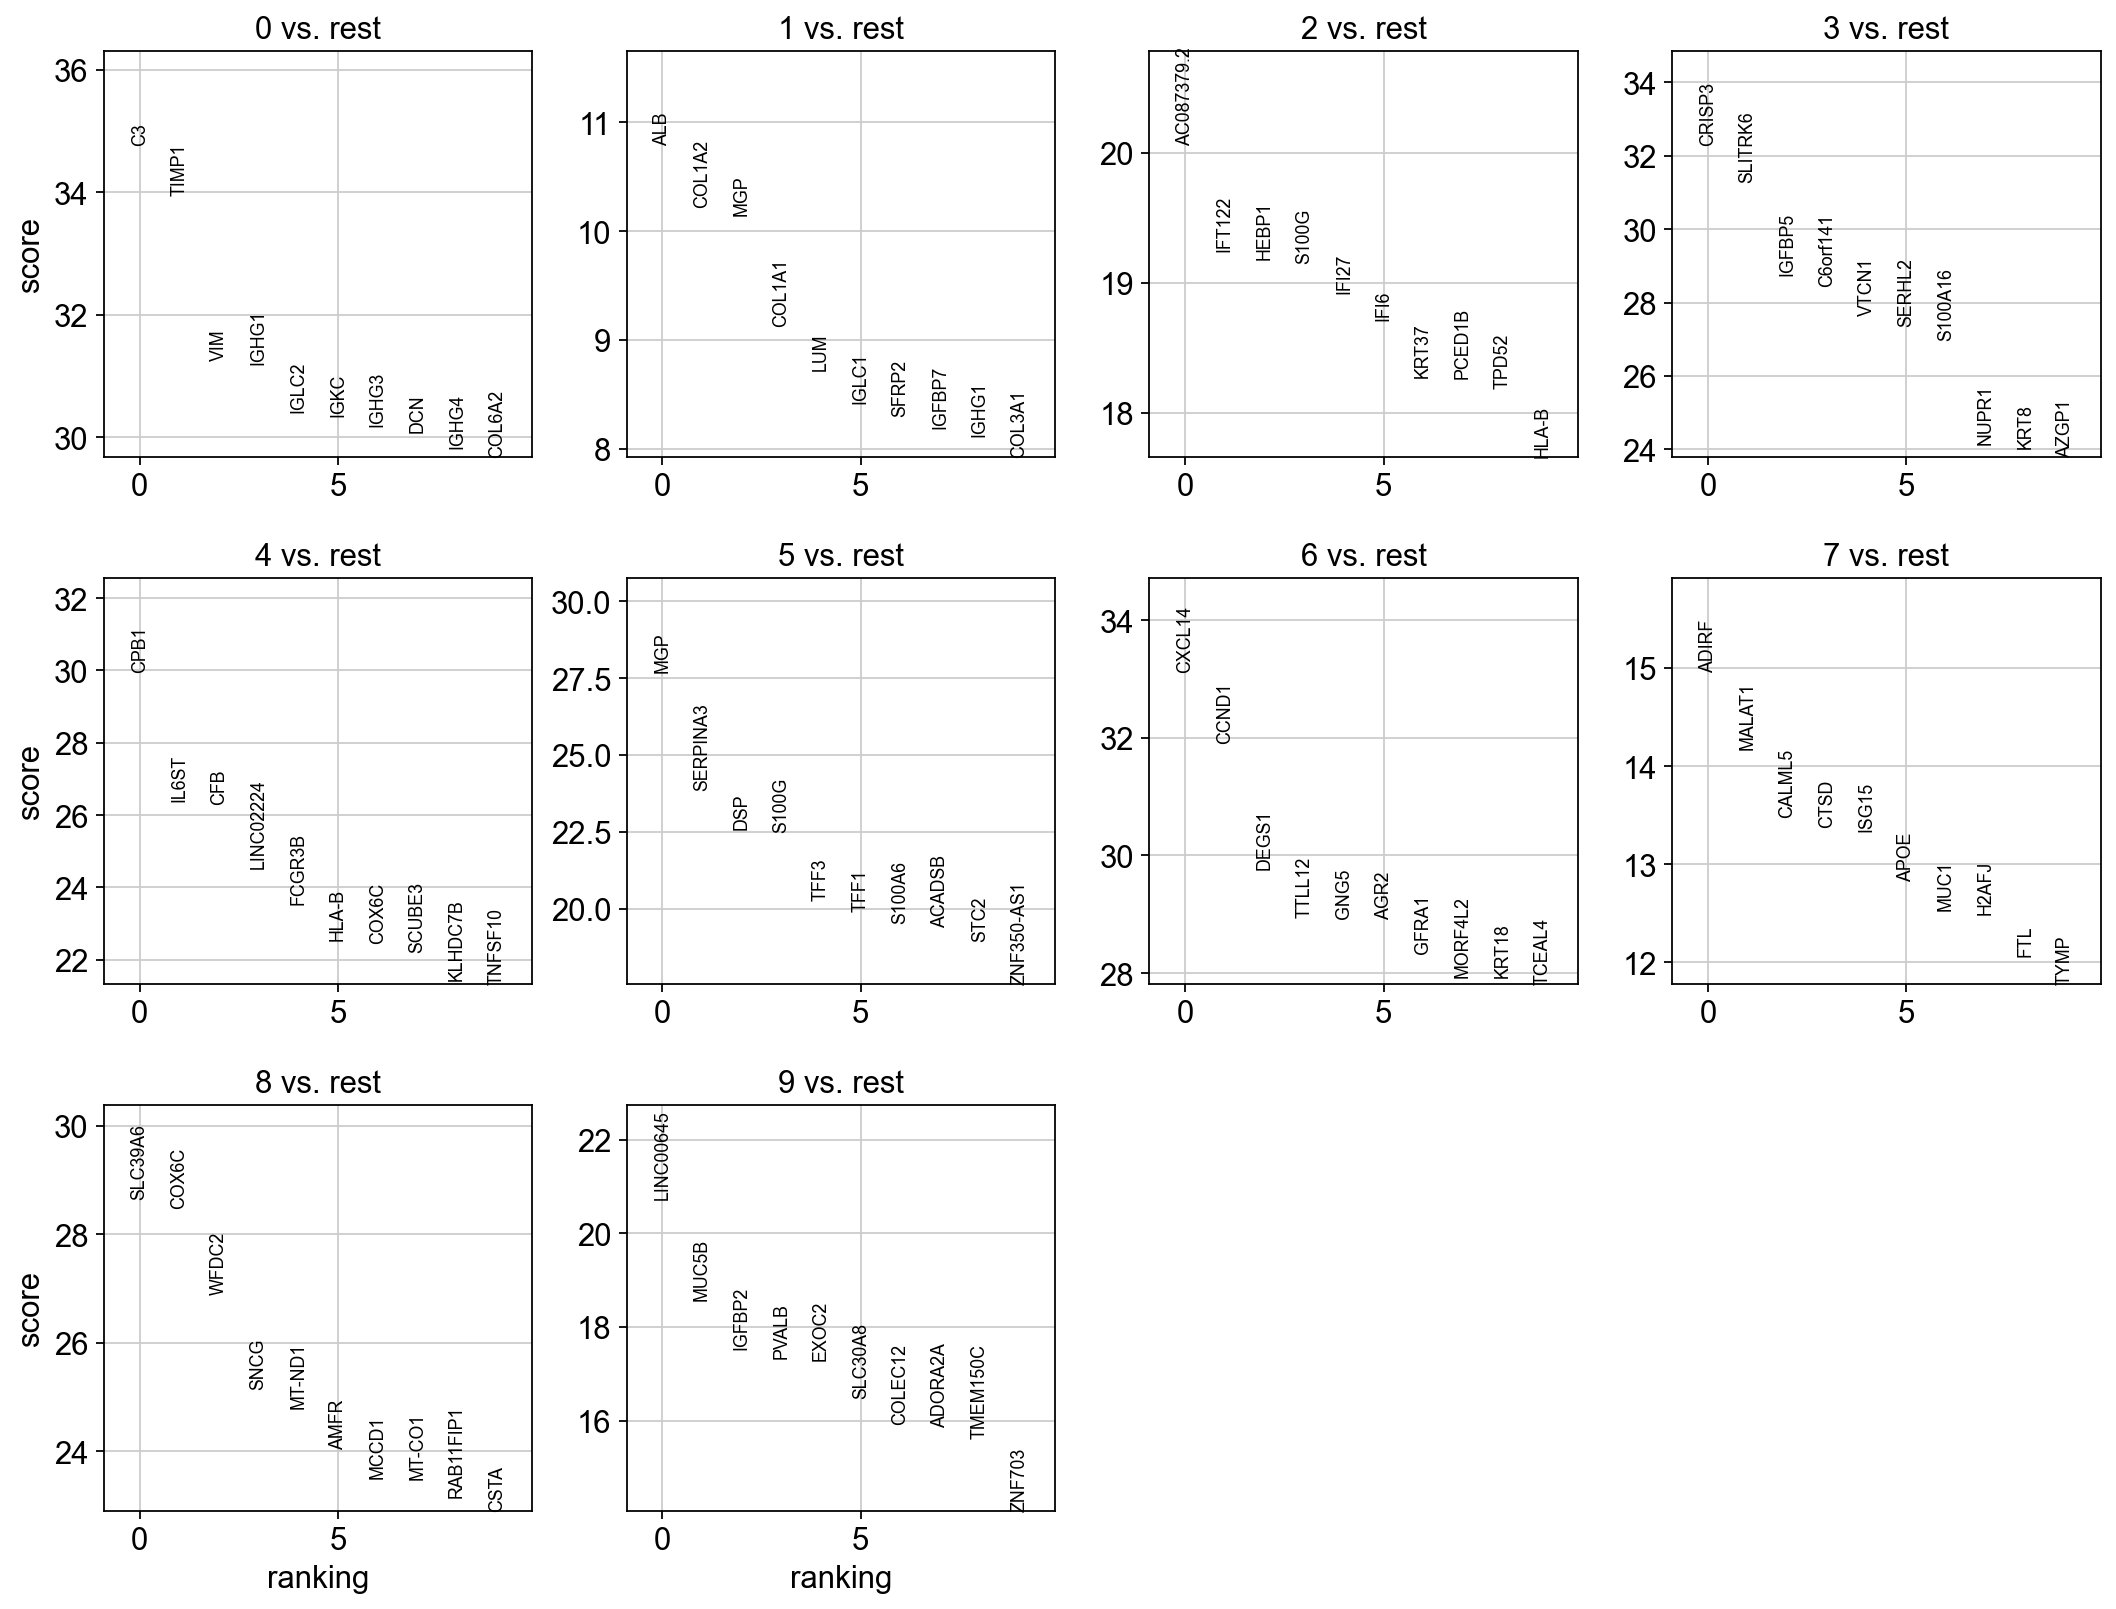

In [31]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)
